<a href="https://colab.research.google.com/github/fugugdeveloper/Bert-Based-Comment-Classification/blob/master/comment_classification_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, multilabel_confusion_matrix
from datasets import Dataset, load_metric
from transformers import (    TrainingArguments, Trainer, DataCollatorWithPadding, TrainerCallback
)
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import os
from torch.nn.functional import sigmoid
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
#to avoid warnings
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/nlp_dataset'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/nlp_dataset


##  **Load and prepare our dataset**

In [ ]:
df = pd.read_csv("training/train.csv")
display(df.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## **Plot class distribution for Analyzing our Dataset**

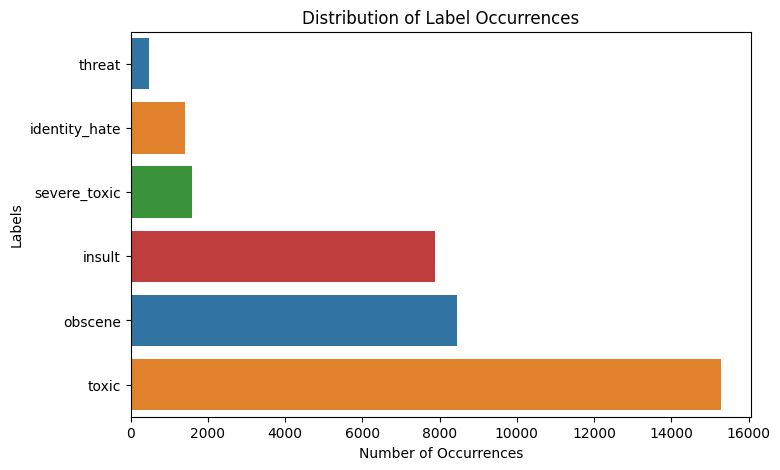

In [ ]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
column_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = df[column_labels].sum().sort_values()
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette=custom_colors)
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')
plt.show()


## **Counting Labels Values for better understanding**

In [ ]:
df[column_labels].sum().sort_values()

,0
threat,478
identity_hate,1405
severe_toxic,1595
insult,7877
obscene,8449
toxic,15294


## **Create subsets based on toxic and non-toxic comments**

In [ ]:
df_toxic = df[df[column_labels].sum(axis=1) > 0]
df_non_toxic = df[df[column_labels].sum(axis=1) == 0]


## **Display Clean Comments**

In [ ]:
display(df_non_toxic)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


## **Display Toxic Comments**

In [ ]:
display(df_toxic)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


## **Visualize toxic vs. non-toxic distribution**

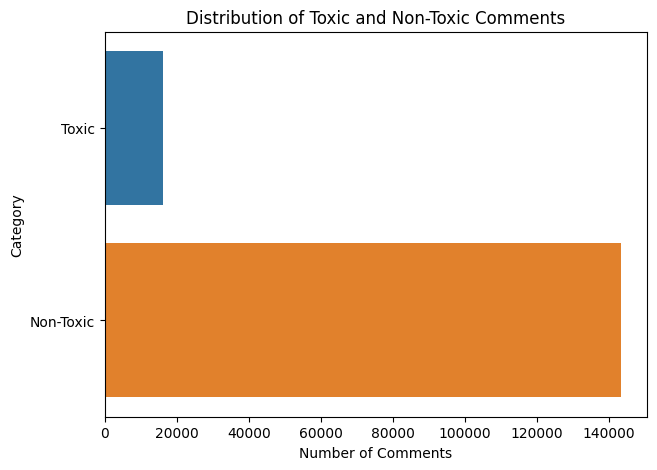

In [ ]:
num_toxic = len(df_toxic)
num_clean = len(df_non_toxic)
plot_data = pd.DataFrame({'Category': ['Toxic', 'Non-Toxic'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize=(7, 5))
sns.barplot(x='Count', y='Category', data=plot_data, palette=custom_colors)
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Non-Toxic Comments')
plt.show()


## **Downsample clean comments for balancing and this is optional**

In [ ]:
df_non_toxic_sampled = df_non_toxic.sample(n=len(df_toxic), random_state=42)
df_balanced = pd.concat([df_toxic, df_non_toxic_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
display(df_balanced)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,9a8103881a1d8372,You are an old cougar! You are an old cougar!,1,0,0,0,1,0
1,7c9a37dc040d6ef4,I'm scared\nbrrrr.... i'm gonna die now,0,0,0,0,0,0
2,df07677ce31a782d,"Okay, so anal sex is as widely unaccepted and ...",1,0,0,0,0,0
3,5c854590da41ac65,shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,1,0,1,0,1,0
4,49cfe7691eb59201,You arrogant administrator homosexual bastards...,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...
32445,3391e899b12abdf6,Wendy Davis \nPlease remember that you can dev...,0,0,0,0,0,0
32446,8c37eb95400cbeca,"Stop wanking so much. Remember, only lotion pr...",1,0,0,0,0,0
32447,15abaa783a453d4f,"Useless piece of shit \n\nYou're an asshole, y...",1,1,1,0,1,0
32448,bd36b386754697e4,N!GGA PU$$Y LICK B!TCH!!!!!!!!!!!!!!!!!!!!!!!,1,0,1,0,1,1


## **Plot label distribution on balanced dataset**

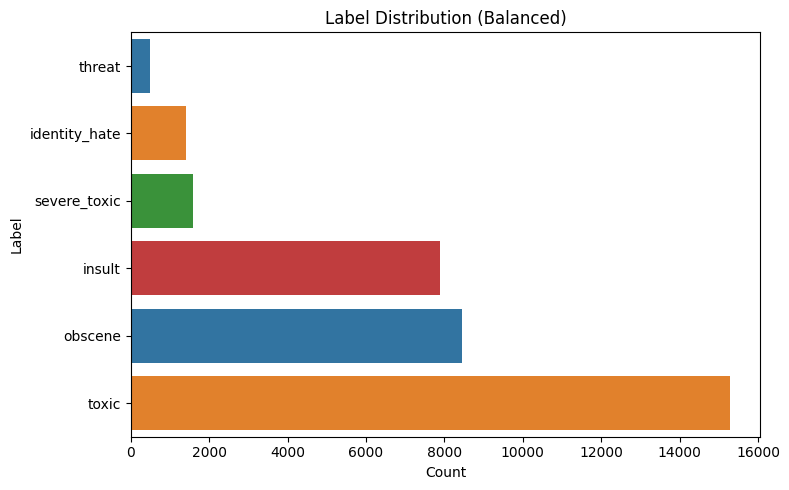

In [ ]:
#df_balanced[column_labels].sum().sort_values().plot(kind='barh', title='Label Distribution (Balanced)')
plot_balanced_data = df_balanced[column_labels].sum().sort_values()
plot_balanced_data = plot_balanced_data.reset_index()
plot_balanced_data.columns = ['Label', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(x='Count', y='Label', data=plot_balanced_data, palette=custom_colors)
plt.title('Label Distribution (Balanced)')
plt.xlabel('Count')
plt.ylabel('Label')
plt.tight_layout()
plt.show()


## **Preparing Data for train by splitting data into training, testing sets & validation sets**

In [ ]:
dataframe = df_balanced.sample(frac=1, random_state=42)
train_texts, test_texts, train_labels, test_labels = train_test_split(
	dataframe['comment_text'], dataframe.iloc[:, 2:], test_size=0.25, random_state=42)

test_texts, val_texts, test_labels, val_labels = train_test_split(
	test_texts, test_labels, test_size=0.5, random_state=42)

## **Encoder and Tokenizer Function**

In [ ]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    input_ids, attention_masks = [], []
    for comment in comments:
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.float32)
    return input_ids, attention_masks, labels

## **Tokenization using BertTokenizer**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
										do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## **Load and Initialize Our Model**

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=6, problem_type='multi_label_classification'
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Encode training and validation Data**

In [ ]:
train_input_ids, train_attention_masks, train_labels_tensor = tokenize_and_encode(tokenizer, train_texts, train_labels.values)

val_input_ids, val_attention_masks, val_labels_tensor = tokenize_and_encode(tokenizer, val_texts, val_labels.values)

test_input_ids, test_attention_masks, test_labels_tensor = tokenize_and_encode(tokenizer, test_texts, test_labels.values)
print('Training Comments :',train_texts.shape)
print('Input Ids		 :',train_input_ids.shape)
print('Attention Mask :',train_attention_masks.shape)
print('Labels		 :',train_labels_tensor.shape)

Training Comments : (24337,)
Input Ids		 : torch.Size([24337, 128])
Attention Mask : torch.Size([24337, 128])
Labels		 : torch.Size([24337, 6])


## **Create TensorDatasets and DataLoaders**

In [ ]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels_tensor)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])


Batch Size : 16
Each Input ids shape : torch.Size([16, 128])
Input ids :
 tensor([  101,  1045,  2245,  1045,  2056,  1045,  2001,  3374,  2017, 11083,
        19085,   999,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     

## **Optimizer and Scheduler setup**

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

## **Device Checking and Move model to GPU if available**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

## **Confusion Matrices Plot Function**

In [ ]:
def plot_confusion_matrices(true_labels, pred_labels, classes):
    cm = multilabel_confusion_matrix(true_labels, pred_labels)
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, (ax, label) in enumerate(zip(axes, classes)):
        sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f"Confusion Matrix: {label}")
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    plt.tight_layout()
    plt.show()


## **Training loop with early stopping**

Epoch 1 - Training Loss: 0.1323
Epoch 1 - Validation Loss: 0.1459

 Classification Report (Validation Set):
               precision    recall  f1-score   support

        toxic       0.90      0.95      0.92      1957
 severe_toxic       0.43      0.53      0.48       203
      obscene       0.82      0.91      0.86      1078
       threat       0.56      0.42      0.48        60
       insult       0.74      0.85      0.79      1021
identity_hate       0.70      0.60      0.64       182

    micro avg       0.81      0.88      0.84      4501
    macro avg       0.69      0.71      0.69      4501
 weighted avg       0.81      0.88      0.84      4501
  samples avg       0.41      0.44      0.41      4501



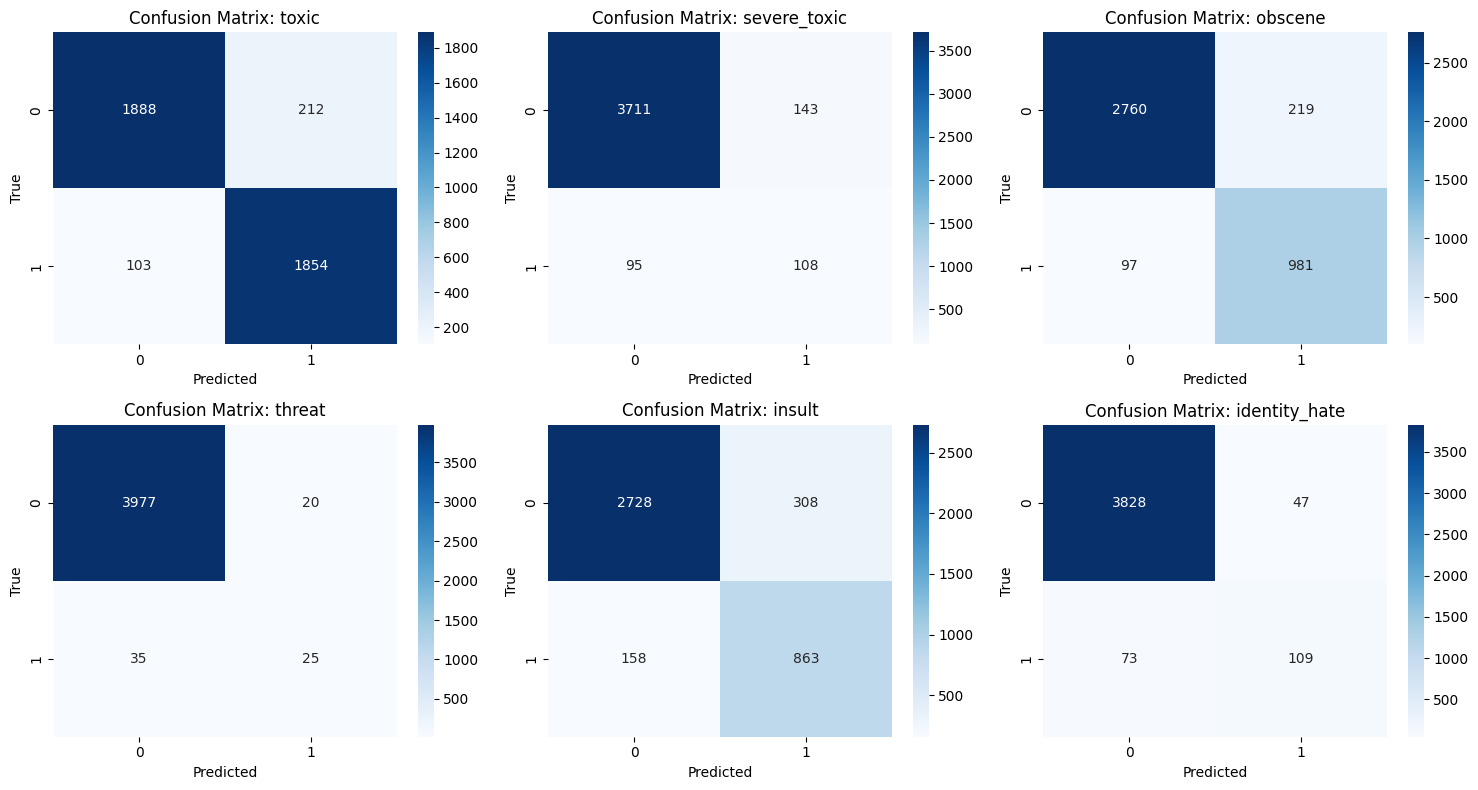

Epoch 2 - Training Loss: 0.1085
Epoch 2 - Validation Loss: 0.1534

 Classification Report (Validation Set):
               precision    recall  f1-score   support

        toxic       0.90      0.94      0.92      1957
 severe_toxic       0.52      0.49      0.51       203
      obscene       0.85      0.87      0.86      1078
       threat       0.58      0.47      0.52        60
       insult       0.81      0.77      0.79      1021
identity_hate       0.66      0.53      0.59       182

    micro avg       0.84      0.84      0.84      4501
    macro avg       0.72      0.68      0.70      4501
 weighted avg       0.83      0.84      0.84      4501
  samples avg       0.42      0.42      0.41      4501



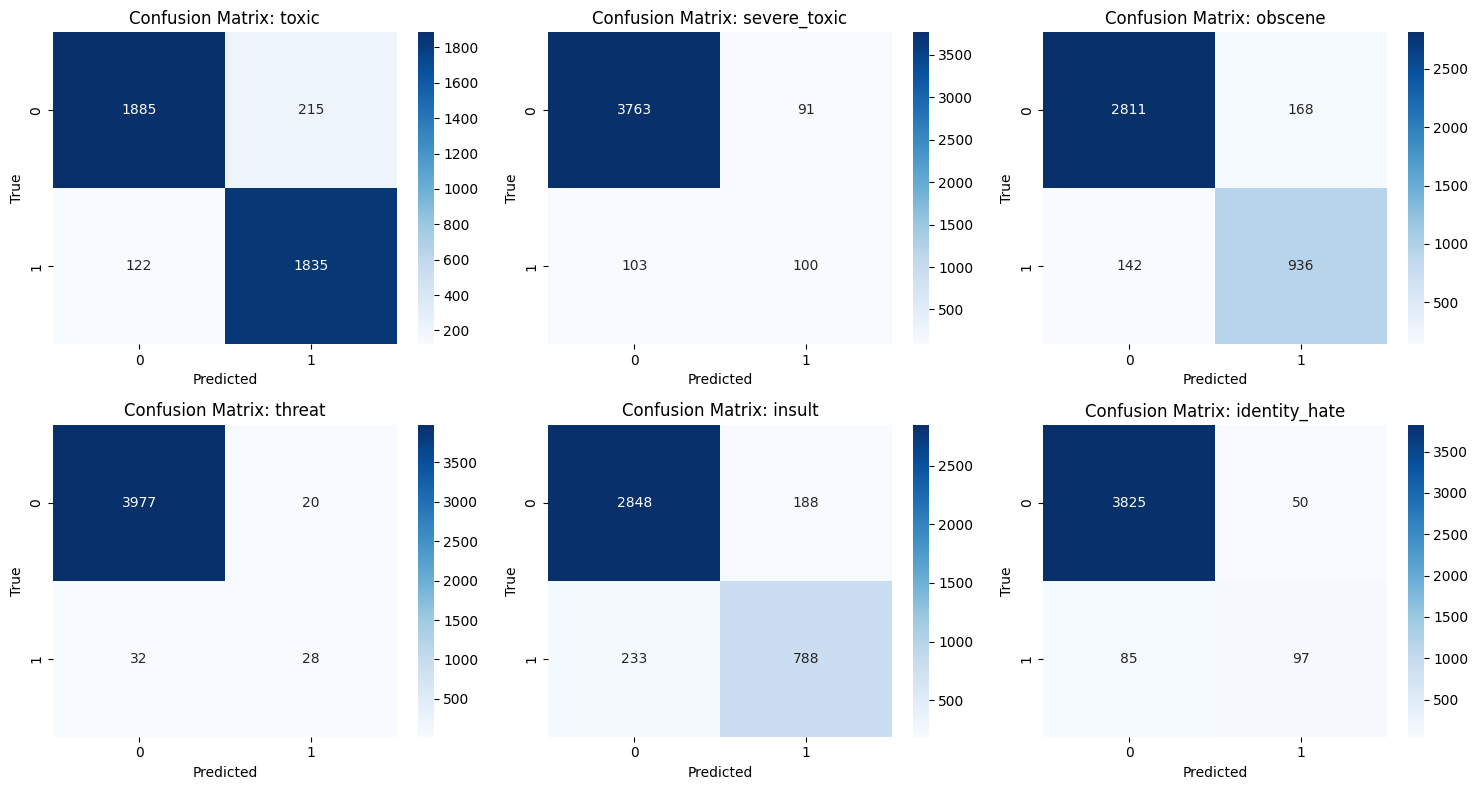

Epoch 3 - Training Loss: 0.0860
Epoch 3 - Validation Loss: 0.1672
Early stopping triggered.


In [ ]:
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "model-results/best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = sigmoid(outputs.logits).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    print("\n Classification Report (Validation Set):")
    print(classification_report(all_labels, all_preds, target_names=column_labels, zero_division=0))
    plot_confusion_matrices(all_labels, all_preds, column_labels)


## **Model Evaluation on Test Data or Unseen Data**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_model(model, test_loader, device):
	model.eval()
	true_labels = []
	predicted_probs = []

	with torch.no_grad():
		for batch in test_loader:
			input_ids, attention_mask, labels = [t.to(device) for t in batch]
			outputs = model(input_ids, attention_mask=attention_mask)
			predicted_probs_batch = torch.sigmoid(outputs.logits)
			predicted_probs.append(predicted_probs_batch.cpu().numpy())

			true_labels_batch = labels.cpu().numpy()
			true_labels.append(true_labels_batch)

	true_labels = np.concatenate(true_labels, axis=0)
	predicted_probs = np.concatenate(predicted_probs, axis=0)
	predicted_labels = (predicted_probs > 0.5).astype(int)

	accuracy = accuracy_score(true_labels, predicted_labels)
	precision = precision_score(true_labels, predicted_labels, average='micro')
	recall = recall_score(true_labels, predicted_labels, average='micro')

	print(f'Accuracy: {accuracy:.4f}')
	print(f'Precision: {precision:.4f}')
	print(f'Recall: {recall:.4f}')



## **Call the evaluate function to evaluate the model on the test data**

In [ ]:
evaluate_model(model, test_loader, device)

Accuracy: 0.6990
Precision: 0.7984
Recall: 0.8470


## **Save Model and Tokenizer**

In [ ]:
model.save_pretrained("model-results")
tokenizer.save_pretrained("model-results")

('model-results/tokenizer_config.json',
 'model-results/special_tokens_map.json',
 'model-results/vocab.txt',
 'model-results/added_tokens.json')

## **Load saved Model and Tokenizer**

In [ ]:
loaded_model = BertForSequenceClassification.from_pretrained("model-results")
loaded_tokenizer = BertTokenizer.from_pretrained("model-results")
loaded_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## **Predict function for User Input**

In [ ]:
def predict_user_input(input_text, model, tokenizer, device):
    model.eval()
    encodings = tokenizer([input_text], truncation=True, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encodings)
        probs = sigmoid(outputs.logits).squeeze().cpu().numpy()
    labels_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    preds = (probs > 0.5).astype(int)
    return {label: int(pred) for label, pred in zip(labels_list, preds)}

## **Test Predictions**

In [ ]:
example_comments = [
    "You are disgusting.",
    "I love this community!",
    "Get lost you moron.",
    "Thank you for your help!"
]

for text in example_comments:
    print(f"\n {text}")
    print("Prediction:", predict_user_input(text, loaded_model, loaded_tokenizer, device))



 You are disgusting.
Prediction: {'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 1, 'identity_hate': 0}

 I love this community!
Prediction: {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

 Get lost you moron.
Prediction: {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}

 Thank you for your help!
Prediction: {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [ ]:
print("Prediction:", predict_user_input("I like my Turkish friends!", loaded_model, loaded_tokenizer, device))


Prediction: {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
